In [1]:
# %pylab notebook
%pylab inline
import pandas as pd
import xarray as xr
import glob, re, os
import scipy
# from scipy import io, optimize
import pickle
import datetime
import netCDF4
from mpl_toolkits.basemap import Basemap
# load the notebook import module, refer to $HOME/usr/szhu_setting/python/szpy, set as $PYTHONPATH
from szpy import nbimport
import szpy.sz as sz

## For debug mode
from IPython.core.debugger import Tracer
#Tracer()() #this one triggers the debugger


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
from importlib import reload
# reload(sz)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Require 'from szpy import nbimport'
ers = __import__('20170523ellipsoid')
# reload(ers)

importing Jupyter notebook from 20170523ellipsoid.ipynb
Populating the interactive namespace from numpy and matplotlib


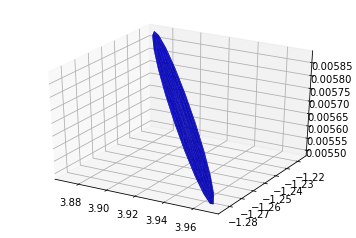

In [3]:
ers.f_plot_E(ers.f_geneigvector(ers.psd))

In [4]:
# Read all source data file for Darwin campaign
# campaign = 'cayenne'
campaign = 'darwin'
sfsrc, ikpsrc, cdpsrc, robsrc, lampsrc = [ xr.open_dataset('tmp/'+campaign+'/'+campaign+'_sync_bulk.nc',group='/'+x)
                      for x in ['saffire','ikp','cdp','robust','lampproc'] ]

rastanamelist = ['w_ret','Mask_Vz','height_2D','w_wind']
rastasrc = xr.merge( [ xr.open_dataset('tmp/'+campaign+'/'+campaign+'_rasta.nc',group='/'+x)
        for x in rastanamelist ] )

mtsatsrc = xr.open_dataset('tmp/'+campaign+'/'+campaign+'_mtsat.nc',group='/mtsatproc',decode_cf=False)
# Note [] {} are comprehension for lsit and dict, while () is a generator, not a tuple compreh
[ mtsatsrc[x].attrs.pop('missing_value') for x in ['longitude','latitude'] ]
mtsatsrc = xr.conventions.decode_cf(mtsatsrc)

modelsrc = xr.open_dataset('tmp/'+campaign+'/'+'ecmwf.nc')
sdsrc = xr.open_dataset('tmp/'+campaign+'/'+campaign+'_sync_gz.nc',group='/lamp')
bin_div = sdsrc.bin_div
bin_diff = diff(bin_div)
bin_mid = (bin_div[1:] + bin_div[:-1])/2

/data/keeling/a/szhu28/usr/anaconda2/envs/py35/lib/python3.5/site-packages/xarray/conventions.py:838: UserWarning: CF decoding is overwriting dtype
  warnings.warn("CF decoding is overwriting dtype")


In [17]:
# Read all source data file for Cayenne campaign
campaign = 'cayenne'
# campaign = 'darwin'
sfsrc, ikpsrc, cdpsrc, robsrc, lampsrc = [ xr.open_dataset('tmp/'+campaign+'/'+campaign+'_sync_bulk.nc',group='/'+x)
                      for x in ['saffire','ikp','cdp','robust','lampproc'] ]

rastanamelist = ['w_ret','Mask_Vz','height_2D','w_wind']
rastasrc = xr.merge( [ xr.open_dataset('tmp/'+campaign+'/'+campaign+'_rasta.nc',group='/'+x)
        for x in rastanamelist ] )

mtsatsrc = xr.open_dataset('tmp/'+campaign+'/'+campaign+'_mtsat.nc',group='/mtsatproc',decode_cf=True)
# Note [] {} are comprehension for lsit and dict, while () is a generator, not a tuple compreh

modelsrc = xr.open_dataset('tmp/'+campaign+'/'+'ecmwf.nc')
sdsrc = xr.open_dataset('tmp/'+campaign+'/'+campaign+'_sync_gz.nc',group='/lamp')
bin_div = sdsrc.bin_div
bin_diff = diff(bin_div)
bin_mid = (bin_div[1:] + bin_div[:-1])/2

In [ ]:
# sf, ikp, cdp, rob, lamp
!/sw/netcdf4-4.2-gnu-4.4.6/bin/ncdump -h tmp/darwin/darwin_sync_bulk.nc

In [ ]:
# rasta
!/sw/netcdf4-4.2-gnu-4.4.6/bin/ncdump -h tmp/darwin/darwin_rasta.nc

In [ ]:
# mtsat
!/sw/netcdf4-4.2-gnu-4.4.6/bin/ncdump -h tmp/darwin/darwin_mtsat.nc
# haha = netCDF4.Dataset('tmp/darwin/darwin_mtsat.nc')
# { x :haha.groups['mtsatproc'].variables[x].long_name 
#  for x in haha.groups['mtsatproc'].variables.keys()
#  if 'long_name' in haha.groups['mtsatproc'].variables[x].ncattrs() }
# haha.close()

In [ ]:
# model
!/sw/netcdf4-4.2-gnu-4.4.6/bin/ncdump -h tmp/darwin/ecmwf.nc

In [5]:
# routine to select a subset of all data except ECMWF model
# selind = np.where(sfsrc.flightnum.values==13)[0]
selind = np.where((ikpsrc.XKBZR5s.values>.5) & (sfsrc.air_temperature_rm.values<-15)  )[0]
#                  & (lampsrc.validbinnum.values>300) )[0]
sf, ikp, cdp, rob, lamp, rasta, mtsat, sd = [ x.isel(timeutc=selind)
    for x in [sfsrc, ikpsrc, cdpsrc, robsrc, lampsrc, rastasrc, mtsatsrc, sdsrc] ]

/data/keeling/a/szhu28/usr/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/data/keeling/a/szhu28/usr/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [12]:
%%capture
%matplotlib notebook
# Required for the next cell
with open('tmp/darwinphasefig.p','rb') as f:
    axb = pickle.load(f)[1]

<IPython.core.display.Javascript object>


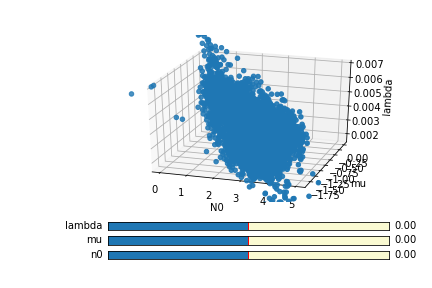

In [13]:
# interactive plot of probing the phase space
%matplotlib notebook
# %matplotlib inline

ax = plt.subplot(111, projection='3d')
plt.subplots_adjust(left=0.25, bottom=0.3)
fig = plt.gcf()
x,y,z = lamp.nml.values.T
ax.scatter(x,y,z)
ax.set_xlabel('N0')
ax.set_ylabel('mu')
ax.set_zlabel('lambda')
# The importance of making a copy here. Otherwise xl changes as the ax is changed.
# xl = ax.get_xlim().copy()
# yl = ax.get_ylim().copy()
# zl = ax.get_zlim().copy()
xl = axb.get_xlim().copy()
yl = axb.get_ylim().copy()
zl = axb.get_zlim().copy()

axcolor = 'lightgoldenrodyellow'
axn0 = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axmu = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
axld = plt.axes([0.25, 0.2, 0.65, 0.03], facecolor=axcolor)

sn0 = Slider(axn0, 'n0', -100., 100., valinit=0.)
smu = Slider(axmu, 'mu', -100., 100., valinit=0.)
sld = Slider(axld, 'lambda', -100., 100., valinit=0.)

def update(wtfisthis):
    global sn0, smu, sld
    ax.set_xlim(xl+(xl[1]-xl[0])*sn0.val/100)
    ax.set_ylim(yl+(yl[1]-yl[0])*smu.val/100)
    ax.set_zlim(zl+(zl[1]-zl[0])*sld.val/100)
    fig.canvas.draw_idle()
sn0.on_changed(update)
smu.on_changed(update)
sld.on_changed(update)
update(None)

def on_key(event):
    global xl,yl,zl
    if event.key == 'right':
        # The importance of making a copy here. Otherwise xl changes as the ax is changed.
        xl = ax.get_xlim().copy()
        yl = ax.get_ylim().copy()
        zl = ax.get_zlim().copy()
        [ x.set_val(0) for x in [sn0,smu,sld] ]
    elif event.key == 'left':
        [ x.set_val(0) for x in [sn0,smu,sld] ]
cid = fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()

In [28]:
sf.timeutc

<xarray.DataArray 'timeutc' (timeutc: 45844)>
array(['2014-01-16T22:33:15.000000000', '2014-01-16T22:33:16.000000000',
       '2014-01-16T22:33:17.000000000', ..., '2014-02-19T00:01:25.000000000',
       '2014-02-19T00:01:26.000000000', '2014-02-19T00:01:27.000000000'], dtype='datetime64[ns]')
Coordinates:
  * timeutc  (timeutc) datetime64[ns] 2014-01-16T22:33:15 ...

In [39]:
ikp

<xarray.Dataset>
Dimensions:   (timeutc: 45844)
Coordinates:
  * timeutc   (timeutc) datetime64[ns] 2014-01-16T22:33:15 ...
Data variables:
    Slat      (timeutc) float64 -13.25 -13.25 -13.25 -13.25 -13.25 -13.25 ...
    Slong     (timeutc) float64 125.1 125.1 125.1 125.1 125.1 125.1 125.1 ...
    SIAltm    (timeutc) float64 1.136e+04 1.136e+04 1.137e+04 1.137e+04 ...
    SINShead  (timeutc) float64 339.4 339.7 339.5 339.3 338.7 337.8 337.3 ...
    Spress    (timeutc) float64 238.6 238.4 238.4 238.3 238.3 238.3 238.3 ...
    SSAT      (timeutc) float64 -40.2 -40.2 -40.1 -40.3 -40.4 -40.6 -40.5 ...
    STAT      (timeutc) float64 -22.76 -22.6 -22.89 -23.38 -23.43 -23.63 ...
    SRHWVSS   (timeutc) float64 90.2 91.9 91.7 92.4 97.0 97.3 99.8 113.0 ...
    STAS      (timeutc) float64 194.1 195.0 192.8 191.2 191.5 191.5 189.8 ...
    Szaccg    (timeutc) float64 -1.064 0.839 0.654 1.354 0.265 1.422 -0.084 ...
    Swdir     (timeutc) float64 18.7 12.1 17.2 13.6 354.5 345.0 356.5 353.4 ...
  

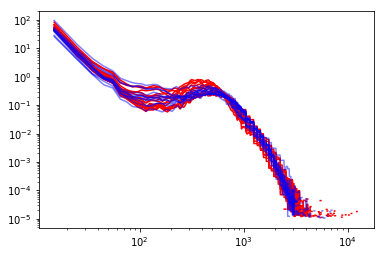

In [58]:
condition = (sf.flightnum==13) & (sf.timeutc>np.datetime64('2014-02-03T05:43')) & (ikp.XKBZR5s>2.2) & (ikp.Slong<129.75) &\
(ikp.Slong>129.55) & (sf.upward_air_velocity>0)
ind = sf.timeutc[condition]

tmp = sf.sel(timeutc=ind)
tmpikp = ikp.sel(timeutc=ind)
tmpsd = sd.sel(timeutc=ind)

psd = tmpsd.psddmax.values

%matplotlib inline
for hehe in psd:
    plt.loglog(bin_mid,hehe,'r')

condition = (sf.flightnum==13) & (sf.timeutc>np.datetime64('2014-02-03T05:43')) & (ikp.XKBZR5s>2.2) & (ikp.Slong<129.75) &\
(ikp.Slong>129.55) & (sf.upward_air_velocity<0)
ind = sf.timeutc[condition]

tmp = sf.sel(timeutc=ind)
tmpikp = ikp.sel(timeutc=ind)
tmpsd = sd.sel(timeutc=ind)

psd = tmpsd.psddmax.values

for hehe in psd:
    plt.loglog(bin_mid,hehe,'b',alpha=.5)
# Red lines are in the updraft core, while blue lines are in the downdraft region